In [1]:
import pandas as pd

In [2]:
# 文件路径
train_file_path = "Xy_train.csv"
val_file_path = "Xy_val.csv"
test_file_path = "Xy_test.csv"

# 读取数据
train_data = pd.read_csv(train_file_path)
val_data = pd.read_csv(val_file_path)
test_data = pd.read_csv(test_file_path)

# 分离特征和目标
X_train = train_data.drop(columns=['target']).values
y_train = train_data['target'].values

X_val = val_data.drop(columns=['target']).values
y_val = val_data['target'].values

X_test = test_data.drop(columns=['target']).values
y_test = test_data['target'].values

# 确认读取结果
print("Train data shape:", X_train.shape, "Target shape:", y_train.shape)
print("Validation data shape:", X_val.shape, "Target shape:", y_val.shape)
print("Test data shape:", X_test.shape, "Target shape:", y_test.shape)

Train data shape: (578421, 9) Target shape: (578421,)
Validation data shape: (123949, 9) Target shape: (123949,)
Test data shape: (123947, 9) Target shape: (123947,)


In [3]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [4]:
# 加载目标值归一化器
target_scaler = joblib.load("target_scaler.pkl")

# 初始化模型
linear_model = LinearRegression()
ridge_model = Ridge(alpha=1.0)  # alpha 控制正则化强度，值越大正则化越强

# 训练模型（仅使用训练集）
linear_model.fit(X_train, y_train)
ridge_model.fit(X_train, y_train)

# 在测试集上预测
y_test_pred_linear = linear_model.predict(X_test)
y_test_pred_ridge = ridge_model.predict(X_test)

# 在验证集上预测
y_val_pred_linear = linear_model.predict(X_val)
y_val_pred_ridge = ridge_model.predict(X_val)

# 反归一化目标值和预测值
y_test_original = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_test_pred_linear_original = target_scaler.inverse_transform(y_test_pred_linear.reshape(-1, 1)).flatten()
y_test_pred_ridge_original = target_scaler.inverse_transform(y_test_pred_ridge.reshape(-1, 1)).flatten()

y_val_original = target_scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()
y_val_pred_linear_original = target_scaler.inverse_transform(y_val_pred_linear.reshape(-1, 1)).flatten()
y_val_pred_ridge_original = target_scaler.inverse_transform(y_val_pred_ridge.reshape(-1, 1)).flatten()

# 评估性能
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} Performance:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R^2 Score: {r2:.4f}")
    print("-" * 30)

# 测试集性能评估（反归一化后的值）
evaluate_model(y_test_original, y_test_pred_linear_original, "Linear Regression (Test Set)")
evaluate_model(y_test_original, y_test_pred_ridge_original, "Ridge Regression (Test Set)")

# 验证集性能评估（反归一化后的值）
evaluate_model(y_val_original, y_val_pred_linear_original, "Linear Regression (Validation Set)")
evaluate_model(y_val_original, y_val_pred_ridge_original, "Ridge Regression (Validation Set)")


NameError: name 'joblib' is not defined

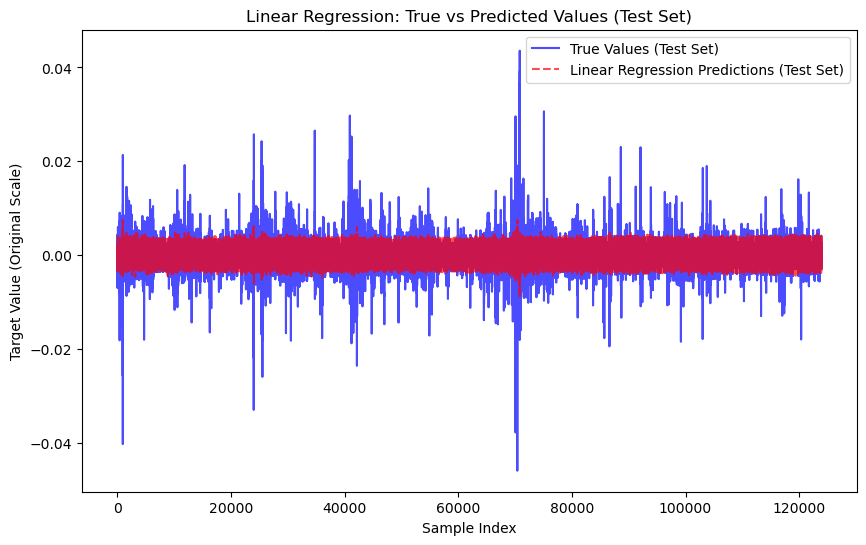

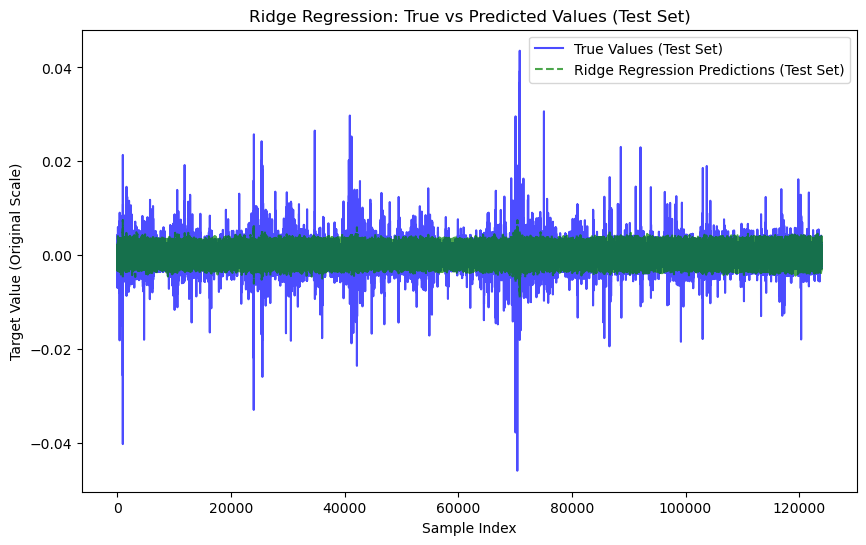

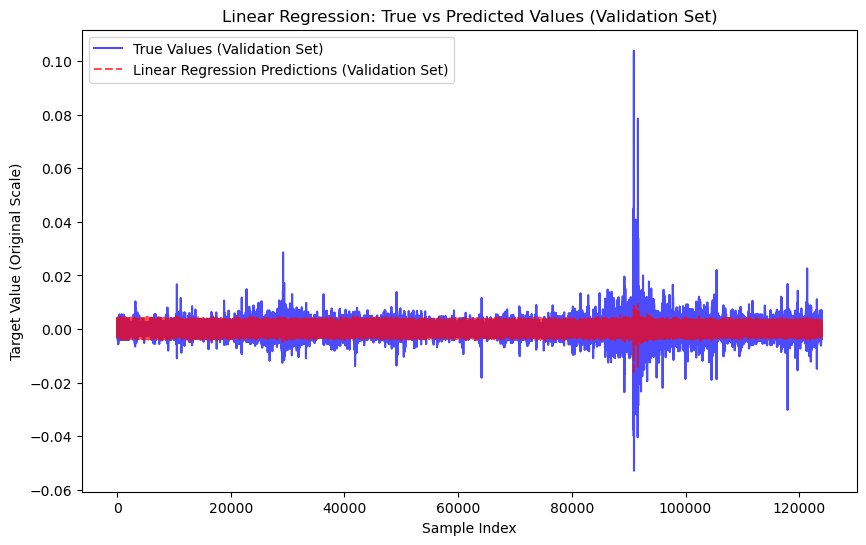

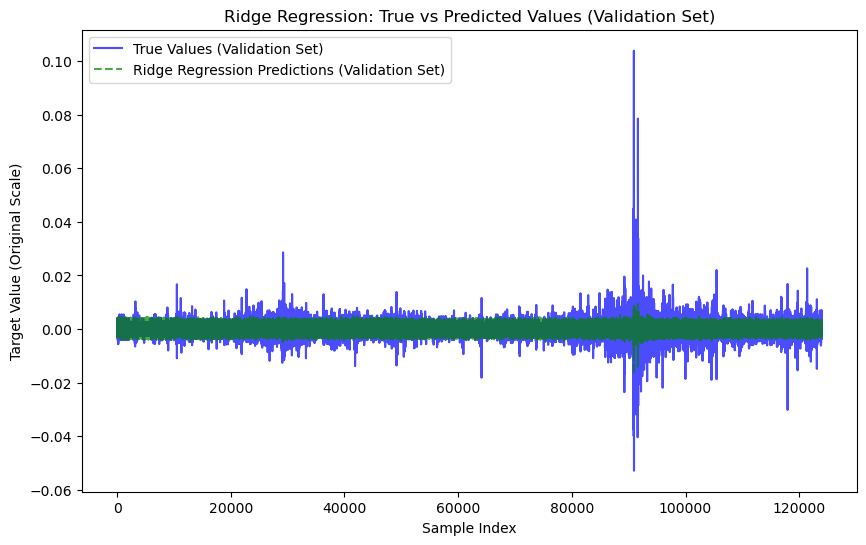

In [ ]:
import matplotlib.pyplot as plt

# Plot for Test Set: Linear Regression
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="True Values (Test Set)", color="blue", alpha=0.7)  # True values
plt.plot(y_test_pred_linear_original, label="Linear Regression Predictions (Test Set)", color="red", linestyle="--", alpha=0.7)  # Predictions
plt.title("Linear Regression: True vs Predicted Values (Test Set)")
plt.xlabel("Sample Index")
plt.ylabel("Target Value (Original Scale)")
plt.legend()
plt.show()

# Plot for Test Set: Ridge Regression
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="True Values (Test Set)", color="blue", alpha=0.7)  # True values
plt.plot(y_test_pred_ridge_original, label="Ridge Regression Predictions (Test Set)", color="green", linestyle="--", alpha=0.7)  # Predictions
plt.title("Ridge Regression: True vs Predicted Values (Test Set)")
plt.xlabel("Sample Index")
plt.ylabel("Target Value (Original Scale)")
plt.legend()
plt.show()

# Plot for Validation Set: Linear Regression
plt.figure(figsize=(10, 6))
plt.plot(y_val_original, label="True Values (Validation Set)", color="blue", alpha=0.7)  # True values
plt.plot(y_val_pred_linear_original, label="Linear Regression Predictions (Validation Set)", color="red", linestyle="--", alpha=0.7)  # Predictions
plt.title("Linear Regression: True vs Predicted Values (Validation Set)")
plt.xlabel("Sample Index")
plt.ylabel("Target Value (Original Scale)")
plt.legend()
plt.show()

# Plot for Validation Set: Ridge Regression
plt.figure(figsize=(10, 6))
plt.plot(y_val_original, label="True Values (Validation Set)", color="blue", alpha=0.7)  # True values
plt.plot(y_val_pred_ridge_original, label="Ridge Regression Predictions (Validation Set)", color="green", linestyle="--", alpha=0.7)  # Predictions
plt.title("Ridge Regression: True vs Predicted Values (Validation Set)")
plt.xlabel("Sample Index")
plt.ylabel("Target Value (Original Scale)")
plt.legend()
plt.show()


In [ ]:
from xgboost import XGBRegressor
import numpy as np

def huber_loss(y_true, y_pred, delta=1.0):
    """自定义 Huber 损失函数"""
    residual = y_true - y_pred
    condition = np.abs(residual) <= delta
    loss = np.where(condition, 0.5 * residual**2, delta * (np.abs(residual) - 0.5 * delta))
    return loss.mean()

# 自定义目标函数
def huber_objective(y_true, y_pred):
    delta = 0.01  # 设置阈值
    grad = np.where(np.abs(y_true - y_pred) <= delta, y_pred - y_true, delta * np.sign(y_pred - y_true))
    hess = np.where(np.abs(y_true - y_pred) <= delta, 1.0, 0.0)
    return grad, hess

# 将其作为 XGBoost 的目标函数
xgb_model = XGBRegressor(
    objective=huber_objective,  # 自定义目标函数
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=6, 
    subsample=0.8, 
    colsample_bytree=0.8,
    random_state=42
)


XGBoost Regression (Test Set) Performance:
Mean Squared Error (MSE): 2.1648
Mean Absolute Error (MAE): 0.8482
R^2 Score: -557422.4322
------------------------------
XGBoost Regression (Validation Set) Performance:
Mean Squared Error (MSE): 2.2444
Mean Absolute Error (MAE): 0.8642
R^2 Score: -461875.3709
------------------------------


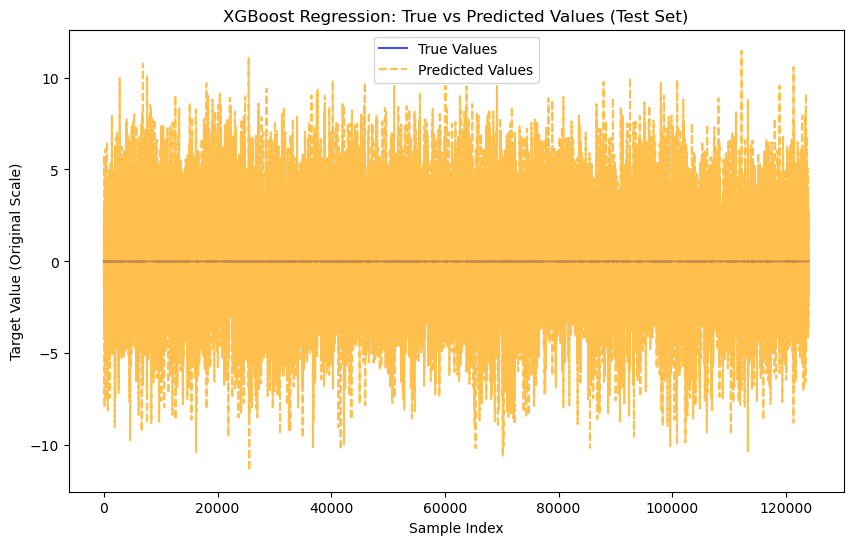

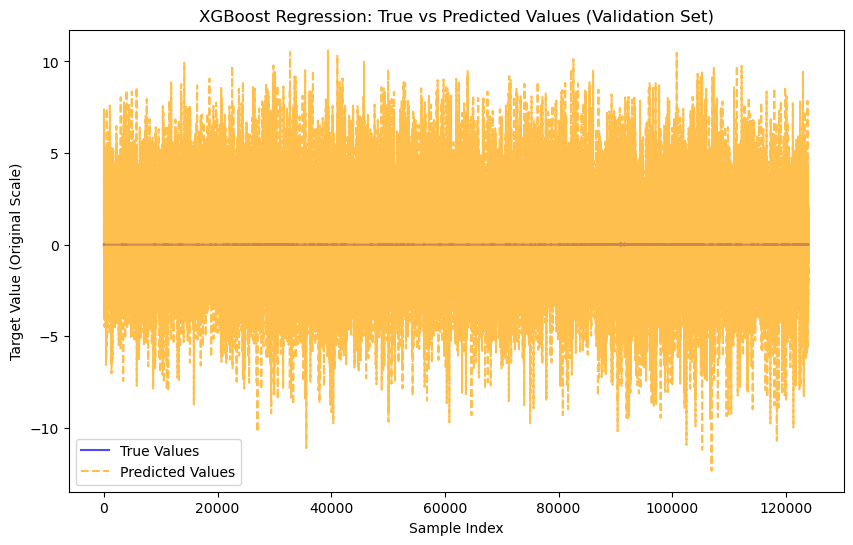

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import joblib

# 加载目标值归一化器
target_scaler = joblib.load("target_scaler.pkl")

# 训练 XGBoost 模型（仅使用训练集）
xgb_model.fit(X_train, y_train)

# 在测试集和验证集上预测
y_test_pred_xgb = xgb_model.predict(X_test)
y_val_pred_xgb = xgb_model.predict(X_val)

# 反归一化目标值和预测值
y_test_original = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_test_pred_xgb_original = target_scaler.inverse_transform(y_test_pred_xgb.reshape(-1, 1)).flatten()

y_val_original = target_scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()
y_val_pred_xgb_original = target_scaler.inverse_transform(y_val_pred_xgb.reshape(-1, 1)).flatten()

# 性能评估函数
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} Performance:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R^2 Score: {r2:.4f}")
    print("-" * 30)

# 测试集性能评估
evaluate_model(y_test_original, y_test_pred_xgb_original, "XGBoost Regression (Test Set)")

# 验证集性能评估
evaluate_model(y_val_original, y_val_pred_xgb_original, "XGBoost Regression (Validation Set)")

# 可视化预测值与真实值
def plot_predictions(y_true, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.plot(y_true, label="True Values", color="blue", alpha=0.7)
    plt.plot(y_pred, label="Predicted Values", color="orange", linestyle="--", alpha=0.7)
    plt.title(title)
    plt.xlabel("Sample Index")
    plt.ylabel("Target Value (Original Scale)")
    plt.legend()
    plt.show()

# 测试集可视化
plot_predictions(y_test_original, y_test_pred_xgb_original, "XGBoost Regression: True vs Predicted Values (Test Set)")

# 验证集可视化
plot_predictions(y_val_original, y_val_pred_xgb_original, "XGBoost Regression: True vs Predicted Values (Validation Set)")


In [ ]:

def calculate_direction_accuracy(y_true, y_pred, model_name):
    """
    y_true: 实际目标列（return.shift(-1)，已反归一化）
    y_pred: 预测值（基于shift(-1)的return预测，已反归一化）
    """
    # 符号一致即方向预测正确
    correct_predictions = (y_true * y_pred) > 0  # 如果 y_true 和 y_pred 同号，乘积为正
    direction_accuracy = correct_predictions.mean()  # 正确预测次数 / 总测试样本数

    # 统计预测上涨和下跌的次数
    predicted_up = (y_pred > 0).sum()  # 预测上涨的次数
    predicted_down = (y_pred < 0).sum()  # 预测下跌的次数

    # 统计实际上涨和下跌的次数
    actual_up = (y_true > 0).sum()  # 实际上涨的次数
    actual_down = (y_true < 0).sum()  # 实际下跌的次数

    # 打印结果
    print(f"{model_name} Direction Prediction Accuracy: {direction_accuracy:.2%}")
    print(f"{model_name} Predicted Up: {predicted_up}, Predicted Down: {predicted_down}")
    print(f"{model_name} Actual Up: {actual_up}, Actual Down: {actual_down}")
    print("-" * 30)

    return direction_accuracy, predicted_up, predicted_down, actual_up, actual_down

# 对线性回归进行方向预测准确率分析
linear_direction_accuracy = calculate_direction_accuracy(y_test_original, y_test_pred_linear_original, "Linear Regression")

# 对岭回归进行方向预测准确率分析
ridge_direction_accuracy = calculate_direction_accuracy(y_test_original, y_test_pred_ridge_original, "Ridge Regression")

# 对 XGBoost 进行方向预测准确率分析
xgb_direction_accuracy = calculate_direction_accuracy(y_test_original, y_test_pred_xgb_original, "XGBoost Regression")
# Correlation y_pred and y_true 5%
# Strategy y_distribution 95% 90% 80% 70% 给signal

Linear Regression Direction Prediction Accuracy: 38.67%
Linear Regression Predicted Up: 64970, Predicted Down: 58977
Linear Regression Actual Up: 44370, Actual Down: 44655
------------------------------
Ridge Regression Direction Prediction Accuracy: 38.67%
Ridge Regression Predicted Up: 64971, Predicted Down: 58976
Ridge Regression Actual Up: 44370, Actual Down: 44655
------------------------------
XGBoost Regression Direction Prediction Accuracy: 39.33%
XGBoost Regression Predicted Up: 65808, Predicted Down: 58139
XGBoost Regression Actual Up: 44370, Actual Down: 44655
------------------------------


In [5]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# 标准化特征
feature_scaler = MinMaxScaler()
X_train_scaled = feature_scaler.fit_transform(X_train)
X_val_scaled = feature_scaler.transform(X_val)
X_test_scaled = feature_scaler.transform(X_test)

# 标准化目标值
target_scaler = MinMaxScaler()
y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_scaled = target_scaler.transform(y_val.reshape(-1, 1)).flatten()
y_test_scaled = target_scaler.transform(y_test.reshape(-1, 1)).flatten()


In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# 构建模型
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),  # Dropout 层防止过拟合
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1)  # 输出层（回归任务的输出为 1 个值）
])

# 编译模型
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 查看模型结构
model.summary()

c:\Apps\anacoda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,281 (67.50 KB)

 Trainable params: 17,281 (67.50 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
from tensorflow.keras.callbacks import EarlyStopping

# 定义早停机制
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 训练模型
history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=100,  # 训练的最大迭代次数
    batch_size=128,  # 批量大小
    callbacks=[early_stopping],  # 早停
    verbose=1
)


Epoch 1/100
4519/4519 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0044 - mae: 0.0351 - val_loss: 1.5283e-04 - val_mae: 0.0090
Epoch 2/100
4519/4519 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 6.0901e-04 - mae: 0.0196 - val_loss: 1.5322e-04 - val_mae: 0.0089
Epoch 3/100
4519/4519 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 5.9624e-04 - mae: 0.0194 - val_loss: 1.7288e-04 - val_mae: 0.0096
Epoch 4/100
4519/4519 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 5.9316e-04 - mae: 0.0194 - val_loss: 1.3960e-04 - val_mae: 0.0083
Epoch 5/100
4519/4519 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 5.9367e-04 - mae: 0.0194 - val_loss: 1.5158e-04 - val_mae: 0.0088
Epoch 6/100
4519/4519 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 5.8772e-04 - mae: 0.0194 - val_loss: 1.4909e-04 - val_mae: 0.0087
Epoch 7/100
4519/4519 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 5.8788e-04 - mae: 0.0194 - val_loss: 1.6112e-04 - val_mae: 0.0091
Epoch 8/100
4519/4519 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 5.9104e-04 - mae: 0.0194 - val_loss: 1

In [9]:
# 在测试集上预测
y_test_pred_scaled = model.predict(X_test_scaled)
y_test_pred = target_scaler.inverse_transform(y_test_pred_scaled)

# 评估性能
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print(f"Neural Network Performance: MSE={mse:.4f}, MAE={mae:.4f}, R^2={r2:.4f}")

3874/3874 ━━━━━━━━━━━━━━━━━━━━ 2s 573us/step
Neural Network Performance: MSE=0.0001, MAE=0.0070, R^2=-0.1046
